In [1]:
import PolynomialRoots.roots
using Distributions
using Plots
using PGFPlotsX
using LaTeXStrings
using LinearAlgebra
using Colors
using JLD
using Parameters
using Random
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

In [2]:
@unpack speech_data, noise_data, rγ, rmθ, rvθ, rmz, rvz, rτ, rmη, rvη, rmx, rvx, fe = JLD.load("jlds/coupled_ar.jld");

In [3]:
function generate_coefficients(order::Int)
    stable = false
    true_a = []
    # Keep generating coefficients until we come across a set of coefficients
    # that correspond to stable poles
    while !stable
        true_a = randn(order)
        coefs =  append!([1.0], -true_a)
        if false in ([abs(root) for root in roots(coefs)] .> 1)
            continue
        else
            stable = true
        end
    end
    return true_a
end

function generateAR(num::Int, order::Int; nvar=1, stat=true, coefs=nothing)
    if isnothing(coefs) && stat
        coefs = generate_coefficients(order)
    end
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(nvar[])), 1)[1])
    end
    data = data[1+3*order:end]
    return coefs, data
end

generateAR (generic function with 1 method)

In [4]:
# auxilary function to check if time-series converge
function infinite_ar(ar_array; lim=10.0)
    for x in ar_array
        if findnext(x -> abs(x) > 10.0, x, 1) !== nothing
            return true
        end
    end
    return false
end

function generateTVAR(num::Int, order::Int; nvar=1.0)
    coefs = Vector{Vector{Float64}}(undef, num+3*order)
    coef_var = rand([1.0, 1e-1, 1e-2])
    coefs[1] = generate_coefficients(order)
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        coefs[i] = rand(MvNormal(coefs[i-1], coef_var))
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Normal(coefs[i]'data[i-1], sqrt(nvar)), 1)[1])
    end
    data = data[1+3*order:end]
    coefs = coefs[1+3*order:end]
    coef_var = coef_var
    return coefs, coef_var, data
end

generateTVAR (generic function with 1 method)

In [4]:
# Random.seed!(42)
# n_datasets = 1002
# n_samples = 100
# AR_z = 5:8
# AR_x = 1:4
# noise_var = [1.0, 0.3, 0.1]
# SNR_s = rand(noise_var, n_datasets)
# speech_data, noise_data = [generateAR(n_samples, rand(AR_z)) for _ in 1:n_datasets], [generateAR(n_samples, rand(AR_x), nvar=SNR_s[i]) for i in 1:n_datasets];

In [11]:
Random.seed!(42)
n_datasets = 1000
n_samples = 100
AR_z = 5:8
AR_x = 1:4
noise_var = [10.0, 1.0, 0.3, 0.1]
i = 0
speech_data = []
while i < n_datasets
    coefs, coef_var, data = generateTVAR(n_samples, rand(AR_z))
    if !infinite_ar(data)
        push!(speech_data, [coefs, coef_var, data])
        i += 1
    end
end;
SNR_s = rand(noise_var, n_datasets)
noise_data = [generateAR(n_samples, rand(AR_x), nvar=SNR_s[i]) for i in 1:n_datasets];

In [12]:
stable_idx = findall(x -> maximum(abs.(first.(x[2]))) < 100, speech_data)
speech_data = speech_data[stable_idx]
noise_data = noise_data[stable_idx];
SNR_s = SNR_s[stable_idx]
n_datasets = length(noise_data)

1000

### Coupled AR inference

In [7]:
# using AIDA
# using ReactiveMP
# import ProgressMeter

# Random.seed!(42)
# vmp_its = 200

# rmx = zeros(n_datasets, n_samples)
# rvx = zeros(n_datasets, n_samples)
# rmθ, rvθ = [], []
# rγ = fill(tuple(.0, .0), n_datasets)

# rmz = zeros(n_datasets, n_samples)
# rvz = zeros(n_datasets, n_samples)
# rmη, rvη  = [], []
# rτ = fill(tuple(.0, .0), n_datasets)

# fe  = zeros(n_datasets, vmp_its)

# ProgressMeter.@showprogress for i in 1:n_datasets
    
#     output = first.(speech_data[i][3]) + first.(noise_data[i][2])
#     ar_speech, ar_env = length(speech_data[i][1]), length(noise_data[i][1])

#     # TO FIX: change prior for AR
#     γ, θ, zs, τ, η, xs, fe[i, :]      = coupled_inference(output, (noise_data[i][1], 1e6*diageye(ar_env)), (1.0, 1.0), ar_speech, ar_env, vmp_its)
#     mz, vz                            = mean.(zs), cov.(zs)
#     mθ, vθ                            = mean(θ), cov(θ)
#     rmz[i, :], rvz[i, :]              = first.(mz), first.(vz)
    
#     push!(rmθ, mθ)
#     push!(rvθ, vθ)
    
#     rγ[i]                             = shape(γ), rate(γ)
    
#     mx, vx                            = mean.(xs), cov.(xs)
#     mη, vη                            = mean(η), cov(η)
#     rmx[i, :], rvx[i, :]              = first.(mx), first.(vx)
#     push!(rmη, mη)
#     push!(rvη, vη)
#     rτ[i]                             = shape(τ), rate(τ)
# end

In [19]:
using AIDA
using ReactiveMP
import ProgressMeter

Random.seed!(42)
vmp_its = 200

rmx = zeros(n_datasets, n_samples)
rvx = zeros(n_datasets, n_samples)
rmθ, rvθ = [], []
rγ = fill(tuple(.0, .0), n_datasets)

rmz = zeros(n_datasets, n_samples)
rvz = zeros(n_datasets, n_samples)
rmη, rvη  = [], []
rτ = fill(tuple(.0, .0), n_datasets)

fe  = zeros(n_datasets, vmp_its)

omega = 1e-4
ProgressMeter.@showprogress for i in 1:n_datasets
    try
        output = first.(speech_data[i][3]) + first.(noise_data[i][2])
        ar_speech, ar_env = length(first(speech_data[i][1])), length(noise_data[i][1])

        γ, θ, zs, τ, η, xs, fe[i, :]      = coupled_inference_tvar(output, (noise_data[i][1], inv(omega)*diageye(ar_env)), (1.0, SNR_s[i]), ar_speech, ar_env, vmp_its, ω=speech_data[i][2])
        mz, vz                            = mean.(zs), cov.(zs)
        mθ, vθ                            = mean.(θ), cov.(θ)
        rmz[i, :], rvz[i, :]              = first.(mz), first.(vz)

        push!(rmθ, mθ)
        push!(rvθ, vθ)

        rγ[i]                             = shape(γ), rate(γ)

        mx, vx                            = mean.(xs), cov.(xs)
        mη, vη                            = mean(η), cov(η)
        rmx[i, :], rvx[i, :]              = first.(mx), first.(vx)
        push!(rmη, mη)
        push!(rvη, vη)
        rτ[i]                             = shape(τ), rate(τ)
    catch
        continue
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 1:33:23


In [6]:
function coefs_plt(coefs, mcoefs, vcoefs)
    plot(coefs, label="hidden")
    plot!(mcoefs, ribbon=sqrt.(vcoefs), label="inferred")
end

coefs_plt (generic function with 1 method)

In [7]:
gr()
index = 999
coefs_ = speech_data[index][1];
coefs_plts = map(x -> coefs_plt(getindex.(coefs_, x), getindex.(rmθ[index], x), (getindex.(diag.(rvθ[index]), x))), 1:length(coefs_[1]));

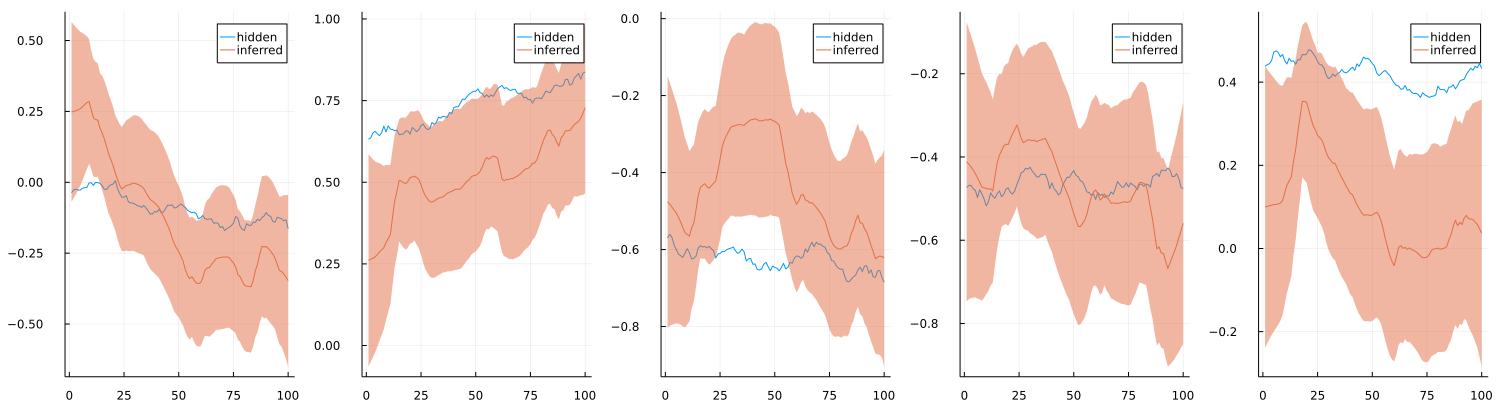

In [8]:
plot(coefs_plts..., layout=grid(1, length(coefs_plts)), size=(1500, 400))

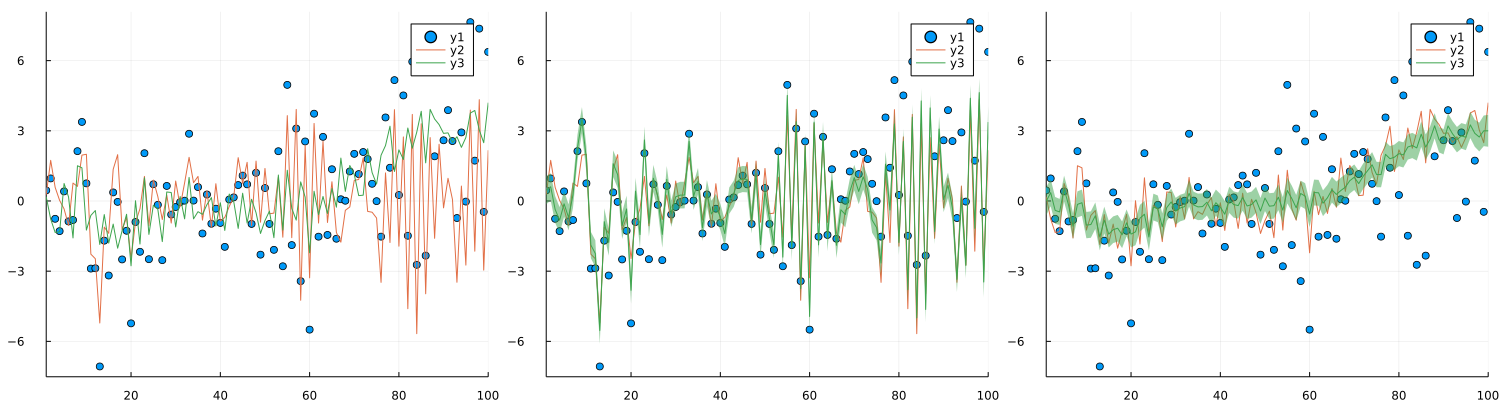

In [9]:
gr()
ar_1, ar_2 = first.(speech_data[index][3]), first.(noise_data[index][2])
p0 = scatter(ar_1 .+ ar_2)
p0 = plot!(ar_1)
p0 = plot!(ar_2)
p1 = scatter(ar_1 .+ ar_2)
p1 = plot!(ar_1)
p1 = plot!(rmz[index, :], ribbon=sqrt.(rvz[index, :]))
p2 = scatter(ar_1 .+ ar_2)
p2 = plot!(ar_2)
p2 = plot!(rmx[index, :], ribbon=sqrt.(rvx[index, :]))
plot(p0, p1, p2, layout=grid(1, 3), size=(1500, 400), xlims=(1, 100))

In [13]:
non_converged, converged = [], []
window = 10
tol = 1e-12
for i in 1:n_datasets
    if sum(diff(fe[i, :])[end-window:end]) <= tol
        push!(converged, i)
    else
        push!(non_converged, i)
    end
end

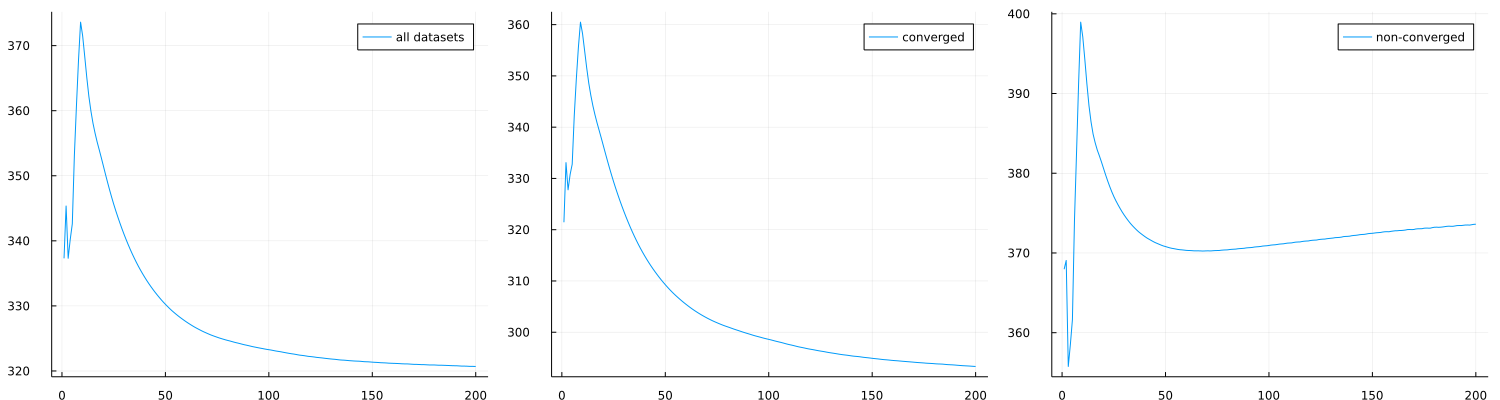

In [15]:
vmp_its = 200

FE = collect(reshape((sum(fe, dims=1)'), (vmp_its, )))/n_datasets
FE_conv = collect(reshape((sum(fe[converged, :], dims=1)'), (vmp_its, )))/size(fe[converged, :], 1)
FE_nonconv = collect(reshape((sum(fe[non_converged, :], dims=1)'), (vmp_its, )))/size(fe[non_converged, :], 1)
plt_all = plot(FE, label="all datasets")
plt_conv = plot(FE_conv, label="converged")
plt_nonconv = plot(FE_nonconv, label="non-converged")
plot(plt_all, plt_conv, plt_nonconv, layout=grid(1, 3), size=(1500, 400))


In [21]:
JLD.save("jlds/coupled_ar.jld", "speech_data", speech_data, "noise_data", noise_data, 
                                "rγ", rγ, "rmθ", rmθ, "rvθ", rvθ, "rmz", rmz, "rvz", rvz, 
                                "rτ", rτ, "rmη", rmη, "rvη", rvη, "rmx", rmx, "rvx", rvx, "fe", fe)

In [643]:
map(x -> coefs_plt(getindex.(coefs_, x), getindex.(rmθ[index], x), (getindex.(diag.(rvθ[index]), x))), 1:length(coefs_[1]));

In [680]:
n_samples = 100
# index = 250
index = 999
coefs_ = speech_data[index][1];

ar_1 = first.(speech_data[index][3])
ar_2 = first.(noise_data[index][2])
output = ar_1 + ar_2

plt_coefs_tvar = @pgf GroupPlot(
    # group plot options
    {
        group_style = {
            group_size = "$(length(coefs_[1])) by 1",
            horizontal_sep = "1.5cm",
        },
    },
    Iterators.flatten(
                      [[
                        {
                            xlabel=L"t",
                            ylabel="value",
                            legend_pos = "south east",
                            legend_cell_align="{left}",
                            grid = "major",
                            title="Coefficient $(x)",
                            legend_style = "{nodes={scale=0.8, transform shape}}",
                         },
                         Plot({no_marks,color="orange"}, Coordinates(collect(1:n_samples), getindex.(coefs_, x))), LegendEntry("hidden"),
                         Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_samples), getindex.(rmθ[index], x))),
                         Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_samples), getindex.(rmθ[index], x) .+  sqrt.(getindex.(diag.(rvθ[index]), x)))),
                         Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_samples), getindex.(rmθ[index], x) .-  sqrt.(getindex.(diag.(rvθ[index]), x)))),
                         Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
                                raw"fill between [of=f and g]"), LegendEntry("inferred")] for x in 1:length(coefs_[1])
                      ]
                     )...,
)

pgfsave("tmp/grouped_coefs_tvar.pdf", plt_coefs_tvar)
pgfsave("tikz/coefs_tvar_$(index).tikz", plt_coefs_tvar)

In [483]:
n_samples = 100
# index = 250
index = 999

ar_1 = first.(speech_data[index][3])
ar_2 = first.(noise_data[index][2])
output = ar_1 + ar_2

plt_coupled_ar = @pgf GroupPlot(
    # group plot options
    {
        group_style = {
            group_size = "3 by 1",
            horizontal_sep = "1.5cm",
        },
    },
    # first
    {xlabel=L"t",
           ylabel="value",
           legend_pos = "south east",
           legend_cell_align="{left}",
           grid = "major",
           title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot(
        {only_marks,color="black",opacity=0.8, mark="x"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:n_samples), y = output
        ),
    ), LegendEntry("observations"),
    Plot({no_marks,color="orange"}, Coordinates(collect(1:n_samples), ar_1)), LegendEntry("AR($(length(speech_data[index][1][1])))"),
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_samples), ar_2)), LegendEntry("AR($(length(noise_data[index][1])))"),
    # second
    {xlabel=L"t",
           legend_pos = "south east",
           legend_cell_align="{left}",
           grid = "major",
           title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot({no_marks,color="orange"}, Coordinates(collect(1:n_samples), ar_1)), LegendEntry("AR($(length(speech_data[index][1][1])))"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_samples), rmz[index, :])),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_samples), rmz[index, :] .+  sqrt.(rvz[index, :]))),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_samples), rmz[index, :] .-  sqrt.(rvz[index, :]))),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred"),
    # third
    {xlabel=L"t",
           legend_pos = "south east",
           legend_cell_align="{left}",
           grid = "major",
        #    ymax = 11,
        #    ymin = -11,
           title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_samples), ar_2)), LegendEntry("AR($(length(noise_data[index][1])))"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_samples), rmx[index, :])),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_samples), rmx[index, :] .+  sqrt.(rvx[index, :]))),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_samples), rmx[index, :] .-  sqrt.(rvx[index, :]))),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
)

pgfsave("tmp/grouped_coupled_ar.pdf", plt_coupled_ar)
pgfsave("tikz/coupled_AR_$(index).tikz", plt_coupled_ar)

In [67]:
# 13 11
index = 13
ar_1 = first.(speech_data[index][2])
ar_2 = first.(noise_data[index][2])
output = ar_1 + ar_2
axis1 = @pgf Axis({xlabel=L"t",
           ylabel="value",
           legend_pos = "south east",
           legend_cell_align="{left}",
           grid = "major",
           title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot(
        {only_marks,color="black",opacity=0.8, mark="x"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:n_samples), y = output
        ),
    ), LegendEntry("observations"),
    Plot({no_marks,color="orange"}, Coordinates(collect(1:n_samples), ar_1)), LegendEntry("AR($(length(speech_data[index][1])))"),
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_samples), ar_2)), LegendEntry("AR($(length(noise_data[index][1])))"),
    )
pgfsave("tmp/coupled_AR_signal.pdf", axis1)
# pgfsave("tikz/coupled_AR_signal.tikz", axis1)

In [140]:
axis2 = @pgf Axis({xlabel=L"t",
           ylabel="value",
           legend_pos = "south east",
           legend_cell_align="{left}",
           grid = "major",
           title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot({no_marks,color="orange"}, Coordinates(collect(1:n_samples), ar_1)), LegendEntry("AR($(length(speech_data[index][1])))"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_samples), rmz[index, :])),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_samples), rmz[index, :] .+  sqrt.(rvz[index, :]))),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_samples), rmz[index, :] .-  sqrt.(rvz[index, :]))),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
    )
pgfsave("tmp/coupled_AR_1_inference.pdf", axis2)
# pgfsave("tikz/coupled_AR_1_inference.tikz", axis2)

In [141]:
axis3 = @pgf Axis({xlabel=L"t",
           ylabel="value",
           legend_pos = "south east",
           legend_cell_align="{left}",
           grid = "major",
           ymax = 7,
           ymin = -7,
           title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_samples), ar_2)), LegendEntry("AR($(length(noise_data[index][1])))"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_samples), rmx[index, :])),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_samples), rmx[index, :] .+  sqrt.(rvx[index, :]))),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_samples), rmx[index, :] .-  sqrt.(rvx[index, :]))),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
    )
pgfsave("tmp/coupled_AR_2_inference.pdf", axis3)
# pgfsave("tikz/coupled_AR_2_inference.tikz", axis3)

In [626]:
# FE
FE = collect(reshape((sum(fe, dims=1)'), (vmp_its, )))/n_datasets
axis4 = @pgf Axis({xlabel="iteration",
                  ylabel="Free energy [nats]",
                  legend_pos = "north east",
                  legend_cell_align="{left}",
                  scale = 1.0,
                  grid = "major",
    },
    Plot({mark = "o", "red", mark_size=1}, Coordinates(collect(1:vmp_its), FE[1:end])), LegendEntry("FE"))

pgfsave("tmp/FE.pdf", axis4)
pgfsave("tikz/FE.tikz", axis4)